# Building a Bot for Food Delivery During COVID-19

During the early days of COVID-19, it was almost impossible to make an online delivery from Whole Foods. Ironically, it was precisely during this time that we had to avoid physically going to the grocery stores as much as possible. I spoke with some friends of mine, and they let me know that in order to get their food delivered, they would mindlessly stare at the computer and hit the refresh page every few seconds until their order would get processed. This process can take hours, and is painfully manual. It is also ripe for automation.

As a result, I designed the following high-level workflow consisting of the following tasks which can be programmed in Python.
1. Use Robotic Process Automation (RPA) to recreate the Amazon checkout process.
2. Take a screenshot of the checkout screen and apply computer vision to detect whether the order can be processed at that particular time.
3. If a timeslot for delivery becomes available, send myself a text message so that I can complete the order. This script runs in the background and I need to take action only when I am notified through my phone. Needless to say, my phone's silent mode needs to be disabled. 
4. Orchestrate tasks 1, 2 and 3 in a workflow that runs at regular, pre-defined intervals. 

I thoroughly enjoyed working on this project because it allowed me to combine 4 disparate skillsets and tools into a single project, namely:
1. RPA - library: rpa (https://github.com/tebelorg/RPA-Python) 
2. Computer vision - library: OpenCV (https://opencv.org/)
3. API - library: Twilio (https://www.twilio.com/docs/usage/api)
4. Workflow scheduling - library: Airflow (https://airflow.apache.org/)

### 1. RPA

Python has an RPA module which is aptly named `rpa`. It allows you to quickly automate tedious, repetitive tasks on the computer. After creating my Whole Foods cart in Amazon.com (which is saved after logging out of the account), I used this package to execute the checkout process. 

In [1]:
!pip install rpa
import rpa as r

First, we will need to open a browser window. Your default browser will open a new blank window.

In [2]:
# open browser
r.init(True) 

True

Then, you can access the Amazon sign in page. 

In [3]:
# go to amazon sign in page
sign_in_url = 'https://www.amazon.com/ap/signin?_encoding=UTF8&openid.assoc_handle=usflex&openid.claimed_id=http%3A%2F%2Fspecs.openid.net%2Fauth%2F2.0%2Fidentifier_select&openid.identity=http%3A%2F%2Fspecs.openid.net%2Fauth%2F2.0%2Fidentifier_select&openid.mode=checkid_setup&openid.ns=http%3A%2F%2Fspecs.openid.net%2Fauth%2F2.0&openid.ns.pape=http%3A%2F%2Fspecs.openid.net%2Fextensions%2Fpape%2F1.0&openid.pape.max_auth_age=0&openid.return_to=https%3A%2F%2Fwww.amazon.com%2Fgp%2Fyourstore%2Fhome%3Fie%3DUTF8%26action%3Dsign-out%26path%3D%252Fgp%252Fyourstore%252Fhome%26ref_%3Dnav_youraccount_signout%26signIn%3D1%26useRedirectOnSuccess%3D1'
r.url(sign_in_url)

True

Enter your username and password. Do not post this information online. 

In [4]:
r.type('text','******[enter]') # enter amazon username here
r.type('text','*******[enter]') # enter password here

True

Then click on Cart, Checkout Whole Foods Market Cart, and the Continue button twice. Notice 'continue' is not capitalized despite being capitalized on the site. This was determined through trial and error. Adjusting the screen size can also have an impact on whether the buttons are successfully found by the software agent.

We now want to take a screenshot of the web page for image processing. To make sure we take a screenshot of the webpage once it's done loading, we wait for a few seconds using `r.wait`. 

In [5]:
r.wait(20) # wait for 20 seconds
r.snap('page','results.png') # save screenshot file as results.png

True

### 2. Computer Vision

Now that we have a snapshot of the checkout page, we want to apply computer vision to check if we get the following message: "No delivery windows available. New windows are released throughout the day." If the message appears, then we need to restart the RPA process described in the previous section. If the message is not found, then we need to receive the text message to process the order. 

In order to find this message, we need to implement the following steps:
1. Read the snapshot as an image.
2. Convert the image to grayscale and save this new image.
3. Apply a technique called thresholding. Thresholding works by tranforming each pixel as either pure black (pixel value 0) or pure white (pixel value 255) depending on where the original pixel value falls in relation to a preset value. 
4. Implement a kernel with a rectangular structural element to the image. 
5. Use dilation on the image to further increase the chances of finding the rectangle contours.
6. Find each rectangle contour in the image and filter by the rectangle which contains the message.
7. Crop this rectangle and apply OCR on this image.
8. Check if the OCR output is equal to the message.

##### Read Image

We use OpenCV's `imread` method to read the image we called `results.png`. 

In [24]:
import cv2
from PIL import Image
from IPython.display import Image
import pytesseract
import numpy as np

filename = 'results.png'
img = cv2.imread(filename)

##### Convert to grayscale

We use the `cvtColor` method to convert the ingested image to grayscale and save the file in the directory. We also close the RPA process since it is no longer needed (`r.close`). The address below was hidden using the blue rectangle. 

In [59]:
imgray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)# convert to gray
filename_gray = filename + '_box.jpg'
cv2.imwrite(filename_gray, imgray)
# r.close()#

True

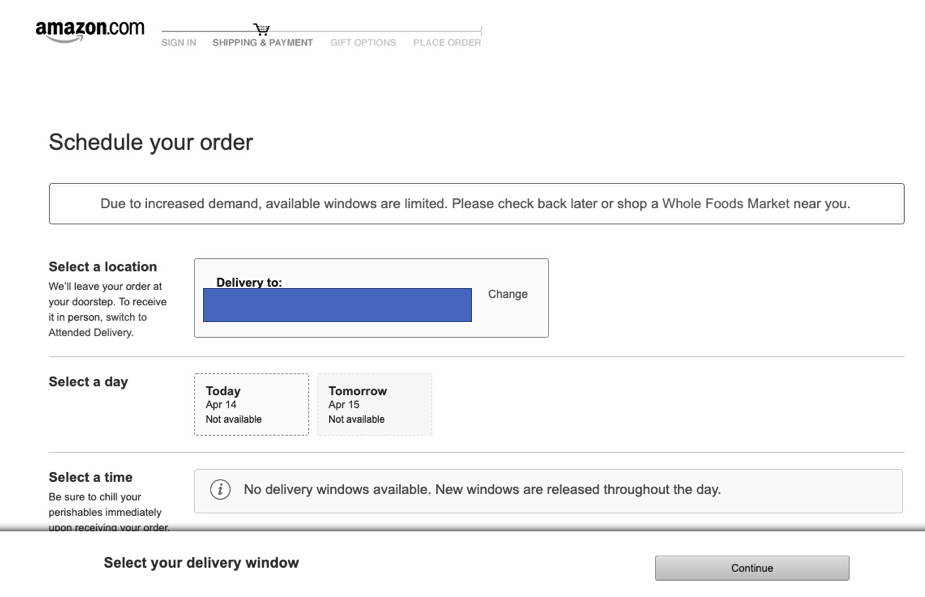

In [60]:
from IPython.display import Image
Image(filename='results.png_box.jpgrect.png') 

##### Thresholding

As previously mentioned, thresholding transforms the grayscale image (pixel values ranging between 0 and 255) to a binary image. If the pixels are higher than 180, they are set to 255 (white), and pixels less than 180 go to 0 (black). The resulting binarized image is shown below.

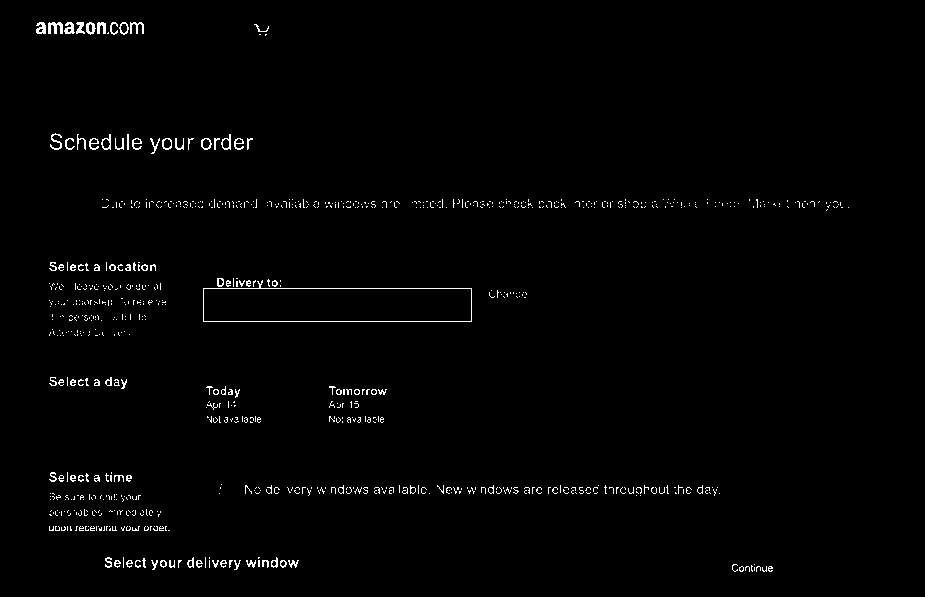

In [61]:
# reading the image
filename = 'results.png_box.jpgrect.png'
img = cv2.imread(filename)
imgray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)# convert to gray

# apply thresholding at a 180 pixel threshold - changed to 100 here for modified imaged 
_,thresh = cv2.threshold(imgray, 100,255, cv2.THRESH_BINARY_INV)

# write image
filename_thresh = 'thresh.png'
cv2.imwrite(filename_thresh, thresh)

# show picture
Image(filename='thresh.png') 

##### Kernel and dilation

We apply two more computer vision techniques to increase the likelihood of finding the boxes with the delivery message: kernel morphing (`cv2.MORPH_RECT`) and dilation (`cv2.dilate`). 

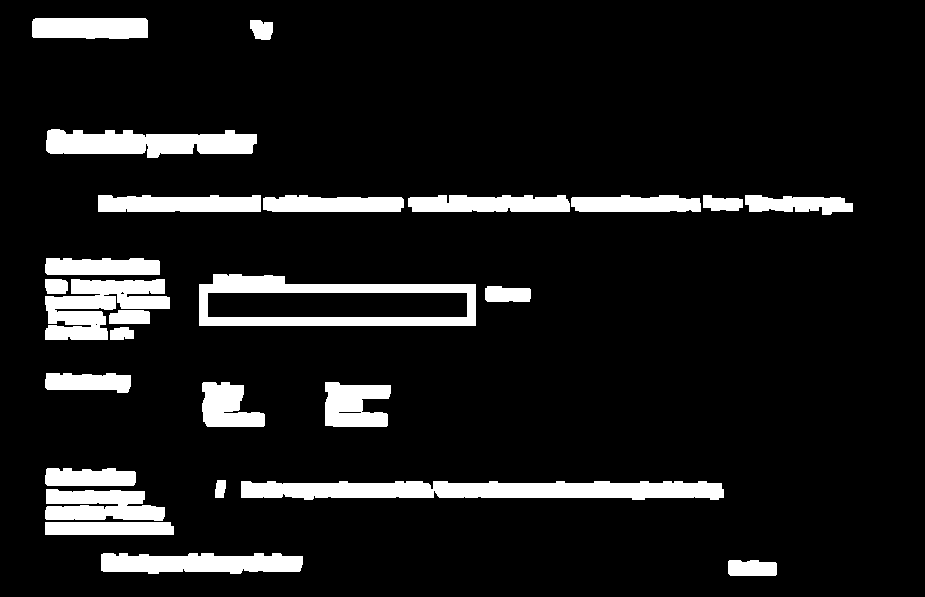

In [62]:
# kernel and dilation
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5)) #rectangle shape
dilated = cv2.dilate(thresh, kernel,iterations=2)

# write image
filename_dilated = 'dilated.png'
cv2.imwrite(filename_dilated, dilated)

# show picture
Image(filename='dilated.png') 

##### Finding contours

Using the dilated image, we can now find the contours for rectangle (`cv2.findContours`), including the one that contains the message with the status delivery. We append the rectangle coordinates into a list and sort them by size. This enables them to be drawn in a single image for validation. 

In [63]:
contours, hierarchy = cv2.findContours(dilated.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_NONE)

box_lst = []
for cnt in contours:
	area = cv2.contourArea(cnt)
	rect=cv2.minAreaRect(cnt)

	box=cv2.boxPoints(rect)
	box=np.int0(box)
	box_lst.append(box)

box_lst = sorted(box_lst, key=cv2.contourArea, reverse=True)

##### Draw contours

Let's now draw the contours to check if we successfully contained the delivery message by using -1 as the parameter in the `cv2.drawContours` method. Looking at the image below, our image processing steps were indeed succesfull in in achieving this goal.

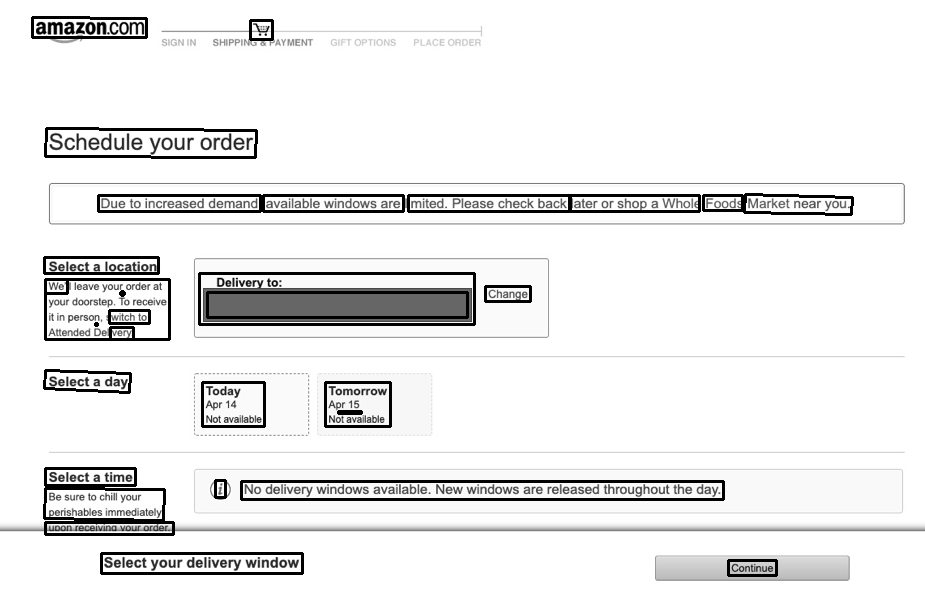

In [46]:
# draw all contours
cv2.drawContours(imgray,box_lst,-1,(0,255,0),2)

# write and show image
cv2.imwrite('contours.png', imgray)
Image(filename='contours.png') 

Let's now only draw the rectangle containing the message by changing the -1 parameter. After trial and error, we see that the parameter 1 will yield the rectangle that we need. Again, the rectangles are sorted by area size - hence it is the rectangle with the second largest area (index starts at 0 instead of 1).

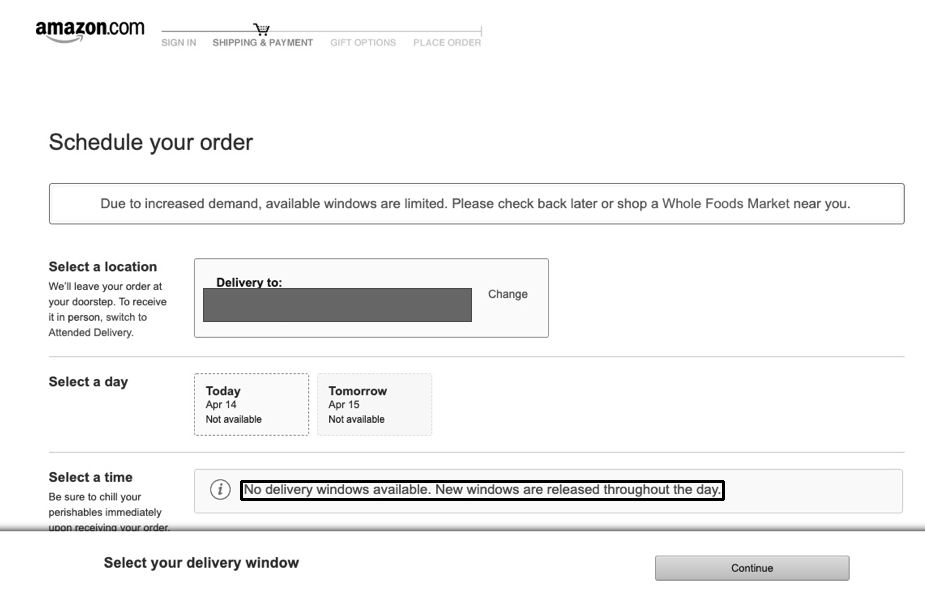

In [65]:
# draw all contours
cv2.drawContours(imgray,box_lst,1,(0,255,0),2)

# write and show image
cv2.imwrite('contours.png', imgray)
Image(filename='contours.png') 

##### Crop the image

We now retrieve the coordinates of the rectangle, crop it and save it as its own image. We will subsequently use this cropped image to convert the message into a string using OCR. We also apply thresholding to this image to increase the accuracy of the OCR model. 

In [67]:
# grab coordinates
coordinates = box_lst[1]
x1 = coordinates[2][0]
x2 = coordinates[0][0]
y1 = coordinates[2][1]
y2 = coordinates[0][1]

# crop image
crop_img = img[y1:y2, x1:x2]

# display cropped image
Image(filename='results.png_box.jpg')

##### OCR using Pytesseract

Python's OCR library, called Pytesseract, can be used to transform the cropped image into a string using `pytesseract.image_to_string`. As shown in the code snippet below, we successfully get the following string stored in the variable `msg`: "No delivery windows available. New windows are released throughout the day."

In [76]:
img = cv2.imread('results.png_box.jpg')
# Adding custom options
# custom_config = r'--oem 3 --psm 6'
msg = pytesseract.image_to_string(img)
print(msg)

No delivery windows available. New windows are released throughout the day.


### 3. Sending an SMS using the Twilio API

Follow the instructions at https://www.twilio.com/sms/api to get the API token and send an SMS using Twilio. Send this message to your phone when the string in the variable `msg` is not equal to the delivery message printed above. My API credentials were redacted for privacy reasons. 

In [81]:
from twilio.rest import Client

# do not share this - need to add number on Twilio to receive text message
# Your Account Sid and Auth Token from twilio.com/console
# DANGER! This is insecure. See http://twil.io/secure
if msg != 'No delivery windows available. New windows are released throughout the day.':
	account_sid = '************'
	auth_token = '************'
	client = Client(account_sid, auth_token)
	message = client.messages.create(
	                              body='notification to order from amazon',
	                              from_='************',
	                              to='************')
else:
	pass

### 4. Airflow

Airflow is a workflow management tool written entirely in Python. It represents workflows as DAGs, namely Directed Acyclic Graphs. Each DAG is a python script stored in a folder called `dags`. DAGs are graphical representations of a sequence of tasks. An example of a DAG is illustrated below. The following blog post includes steps for setting up Airflow: http://michal.karzynski.pl/blog/2017/03/19/developing-workflows-with-apache-airflow/.

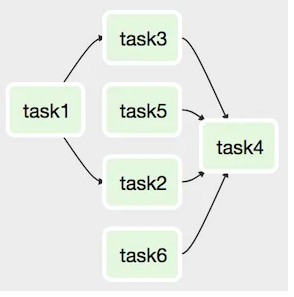

In [83]:
# display DAG image
# https://godatadriven.com/blog/the-zen-of-python-and-apache-airflow/
Image(filename='DAG_illustration.png')

As it's name implies, DAGs have the following properties:
- Directed: there are dependencies between the tasks represented as arrows.
- Acyclic: no cycles can be formed - cycles are problematic because they can lead to infinite loops among tasks.
- Graphs: tasks are the nodes of the graph, and they are linked together via arrows.

In [ ]:
# imports for Airflow to creat DAG scripts - path: airflow/dagsb
from airflow import DAG
from airflow.operators.python_operator import PythonOperator

Each of the RPA and computer vision steps can be now written as tasks, i.e. Python functions. We separate the tasks into the following functions:
- `open_browser()`: opens Chrome as the browser.
- `sign_in_page()`: navigates to the Amazon sign in page.
- `username_pw()`: enters the username and password and hits the enter key.
- `checkout()`: clicks the following buttons on each page successively: Cart, Checkout Whole Foods Market Cart, Continue, Continue.
- `snap()`: take a snapshot the page. 
- `convert_to_greyscale(**context)`: converts image to grayscale.
- `threshold(**context)`: image processing steps including thresholding, kernel morphing and dilation.
- `draw_boxes()`: finds and draws the rectangle around the delivery status message.
- `crop()`: crops rectangle including the message and saves an a separate image.
- `ocr()`: applies thresholding to the cropped image, and renders the image machine-readable using OCR (Pytesseract)
- `send_sms()`: authenticates to the Twilio API and sends an SMS in case a delivery window is available. 

Checkout the DAG on my GitHub repo: https://github.com/kizzen/rpa_for_covid/blob/aa4b72b6e3d563b83d091469774bb171cf33d8d5/airflow/dags/rpa_amzn_redacted_dag.py#L13.

Now the DAG itself can be specified in the script as shown below.

In [ ]:
dag = DAG('rpa_amazn', 
          description='rpa_amazn',
          schedule_interval='0,5,10,15,20,25,30,35,40,45,50,55 * * * *',
          start_date=datetime(2017, 3, 20),
          catchup=False)

This DAG will run every 5 minutes - see the cron notation for the `schedule_interval` parameter above. Each task can now be creating using this DAG definition - given we are using Python functions as tasks, we use the `python_callable` parameters shown below.

In [ ]:
open_browser = PythonOperator(task_id='open_browser', python_callable=open_browser, provide_context=True,dag=dag)
sign_in_page = PythonOperator(task_id='sign_in_page', python_callable=sign_in_page, dag=dag)
username_pw = PythonOperator(task_id='username_pw', python_callable=username_pw, dag=dag)
checkout = PythonOperator(task_id='checkout', python_callable=checkout, dag=dag)
snap = PythonOperator(task_id='snap', python_callable=snap, dag=dag)
convert_to_greyscale = PythonOperator(task_id='convert_to_greyscale', python_callable=convert_to_greyscale, dag=dag)
threshold = PythonOperator(task_id='threshold', python_callable=threshold, provide_context=True,dag=dag)
draw_boxes = PythonOperator(task_id='draw_boxes', python_callable=draw_boxes, dag=dag)
crop = PythonOperator(task_id='crop', python_callable=crop, dag=dag)
ocr = PythonOperator(task_id='ocr', python_callable=ocr, dag=dag)
send_sms = PythonOperator(task_id='send_sms', python_callable=send_sms, dag=dag)

The final step is to set the dependencies for the tasks (the arrows in the graphs) using the `>>` operators. For example, `open_browser >> sign_in_page` means that `open_browser` is the upstream task and `sign_in_page` is the downstream task. 